# W207 Final Group Project: Kaggle Random Acts of Pizza (RAOP)

**Team Members:** Le Gu, Derek S. Chan, and Max (Sungtai) Shen

**Date:** Sunday, April 24, 2016

**Table of Contents**

1. Goal
2. Data Exploration
3. Helper Functions
4. Numerical Feature Engineering
5. Text Feature Engineering
6. Model Optimization
7. Ensemble Method and Final Prediction 
8. Appendix

# 1. Goal
Our team chose the closed Kaggle Competition at https://www.kaggle.com/c/random-acts-of-pizza. It provides a dataset with 5671 rows, each including

1. a posted request for pizza in the Subreddit community, Random Acts of Pizza (RAOP)
2. the outcome of either pizza or no pizza in return, and
3. the meta-data of the requester who posted.
    
Machine learning participants are asked to devise their best algorithm, including their best trained model, to predict which of the requests (that they haven't seen) receive pizza. The Kaggle Competition criterion is to maximize the area under the Receiver Operating Characteristics (ROC) curve, a technique for visualizing, organizing, and selecting classifiers based on performance on true positive rates (predict pizza correctly) vs. false positive rates: predict pizza incorrectly (https://ccrma.stanford.edu/workshops/mir2009/references/ROCintro.pdf). 

Ultimately, Machine learning participants run their best algoritm on a separate Kaggle test dataset; submit to Kaggle their corresponding probabilitstic predictions that requesters receive pizza; and learn their area under the ROC curve per Kaggle.

In [17]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import codecs
import json
import csv

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# 2. Data Exploration

In [18]:
# set random seed
np.random.seed(0)

# input data
X = pd.read_json('./pizza_request_dataset.json')
print ("Input Type after pd.read_jason: "), type(X), "\n" 

#-------------------------------------------------------
# randomly assign 70% to train_data, and 30% to dev_data
#-------------------------------------------------------

msk = np.random.rand(len(X)) <= 0.7
train_data = X[msk]
dev_data = X[~msk]

# create output dataframe Y of train_labels
train_labels = train_data[["requester_received_pizza"]]

# delete train_labels from input dataframe of train_data
del train_data["requester_received_pizza"]

# create output dataframe of dev_labels
dev_labels = dev_data[["requester_received_pizza"]]

# delete dev_labels from input dataframe of dev_data
del dev_data["requester_received_pizza"]

# print (labels, shapes, and feature names
print ("train_labels" + "\n" + "----------")
print (list(train_labels))
print (train_labels.shape), "\n" 

print ("train_data" + "\n" + "----------") 
print (list(train_data))
print (train_data.shape), "\n"

print ("dev_labels" + "\n" + "----------")
print (list(dev_labels))
print (dev_labels.shape), "\n"

print ("dev_data" + "\n" + "----------")
print (list(dev_data))
print (dev_data.shape), "\n"

# print (percent of train_data and dev_data whose posts led to receipt of pizza
print ("train labels" + "\n" + "----------")
print (np.mean(train_labels)), "\n"

print ("dev labels" + "\n" + "----------")
print (np.mean(dev_labels))

Input Type after pd.read_jason:  <class 'pandas.core.frame.DataFrame'> 

train_labels
----------
[u'requester_received_pizza']
(3975, 1) 

train_data
----------
[u'giver_username_if_known', u'in_test_set', u'number_of_downvotes_of_request_at_retrieval', u'number_of_upvotes_of_request_at_retrieval', u'post_was_edited', u'request_id', u'request_number_of_comments_at_retrieval', u'request_text', u'request_text_edit_aware', u'request_title', u'requester_account_age_in_days_at_request', u'requester_account_age_in_days_at_retrieval', u'requester_days_since_first_post_on_raop_at_request', u'requester_days_since_first_post_on_raop_at_retrieval', u'requester_number_of_comments_at_request', u'requester_number_of_comments_at_retrieval', u'requester_number_of_comments_in_raop_at_request', u'requester_number_of_comments_in_raop_at_retrieval', u'requester_number_of_posts_at_request', u'requester_number_of_posts_at_retrieval', u'requester_number_of_posts_on_raop_at_request', u'requester_number_of_pos

In [19]:
# prepare data
# transform X to numpy array, and Y to 1-D numpy array
# view actual text and labels
train_text = train_data["request_text"]
dev_text = dev_data["request_text"]

print ("type(train_text)"), type(train_text)
print ("type(train_labels)"), type(train_labels)
print ("type(dev_text)"), type(dev_text)
print ("type(dev_labels)"), type(dev_labels), "\n"

# View as pandas dataframe
print ("pandas dataframe:")
print (train_text[:5]), "\n"

# convert to numpy (np) array
def to_np(d):

    print ("numpy.ndarray:")
    d = np.array(d)
    d = d.flatten()
    print (type(d))
    print (d.shape)
    print (d[:3])
    print
    return d

train_text = to_np(train_text)
train_labels = to_np(train_labels)
dev_text = to_np(dev_text)
dev_labels = to_np(dev_labels)

print ("train_labels.shape: "), train_labels.shape
print ("dev_labels.shape: "), dev_labels.shape

type(train_text) <class 'pandas.core.series.Series'>
type(train_labels) <class 'pandas.core.frame.DataFrame'>
type(dev_text) <class 'pandas.core.series.Series'>
type(dev_labels) <class 'pandas.core.frame.DataFrame'> 

pandas dataframe:
0    I'm not in College, or a starving artist or an...
2    I'm sure there are needier people on this subr...
3    I've been unemployed going on three months now...
4    I ran out of money on my meal card a while bac...
5                                                     
Name: request_text, dtype: object 

numpy.ndarray:
<type 'numpy.ndarray'>
(3975,)
[ u"I'm not in College, or a starving artist or anything like that. I've just been a bit unlucky lately. I'm a 36 year old single guy with a job. But rent, and other bills killed me this month. I thought I had enough funds in my account to at least keep me set with Mr. Noodles, I forgot about my monthly banking fee.\n\nI had a small bag of chips Wednesday afternoon, and I get paid Monday, so I'll be fine

# 3. Helper Functions
Primarily method to print results and plot ROC curve

In [20]:
#Method for printing out Roc curve
from sklearn.metrics import roc_curve, auc

def model_output(pred_probas, F_Score, preds, title=''):
    print (("Number of positive prediction: %d") % (preds.sum()))
    print ("Model F-Score = %0.4f "%(F_Score))  #Sum up Squared Weights
    accuracy = np.where(preds==dev_labels, 1, 0).sum() / float(len(dev_labels))
    print ("Accuracy = %0.4f" % (accuracy))
    print ('precision_score: %f' % metrics.precision_score(dev_labels, preds))
    print ('recall_score: %0.4f' % metrics.recall_score(dev_labels, preds))

    # to reproduce from Kaggle, don't change weighted argument, just use default above
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    # https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/auc.py
    
    # don't use 0 or 1, instead use the probabilities but think about it as a ranking score.
    # with auc, just want positive examples ranked over the negative examples,
    # does not matter if .99 > .90 or .11 > .01.
    print ('roc_auc_score: %0.4f'% metrics.roc_auc_score(dev_labels, pred_probas[:,1]))
    
    # if just printing, use roc_auc_score as above, computes the roc all at once.
    # if plotting, use roc_auc as below, computes one step at a time.
    # returns the scores at each threshold:
    # e.g., https://hsto.org/files/54b/611/188/54b611188a8b4b2a9ca1e41884f21a3f.png
    
    fpr,tpr,thresholds = roc_curve(dev_labels, pred_probas[:,1])
    table_of_thresholds = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='area = %.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    #return table_of_thresholds

In [21]:
#Method for tuning L1 and L2 regulations
def Model_Tuning(in_model, in_train, in_label):

    para = {'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}
    # create and fit a ridge regression model, testing each alpha
    model = in_model
    grid = GridSearchCV(estimator=model, param_grid=para)
    grid.fit(in_train, in_label)
    print ("The optimal hyperparameter is: ", grid.best_params_)
    return (grid.best_params_)

In [22]:
#Method for L1 regulation and most significant features
def L1_regulation(C_parameter, in_train, in_label):

    model_LG_L1 = LogisticRegression(penalty ='l1',C=C_parameter)#C from the above test
    model_LG_L1.fit(in_train, in_label)

    #Update the new index
    index=[]
    for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
        if z!=0:
            index.append(i)
    return(index)        

# 4. Numerical Feature Engineering

In [23]:
#This is a helper method created for numerical feature extraction
from datetime import date

# define functions for subsequent cell

# take a post and return the estimated average number of words per sentence
def avgNumWords(post):
    sentences = [x.strip() for x in post.split('.')]
    num_words = len(post.split(' '))
    num_sentences = len([x.strip() for x in post.split('.')])
    return num_words / num_sentences

# take a column of dates and return the estimated average number of month since the Subreddit creation
def monthsFrom2010(col):
    temp =  col.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    
    raop_create_date = datetime.datetime(2010, 12, 1)
    raop_create_date = raop_create_date.date()

    temp = [x.date() for x in temp]
    # comment out days, and use months for better results
    #temp = [(x - raop_create_date).days for x in temp]
    temp = [((x - raop_create_date).days)/30 for x in temp]
    
    return temp

                                       Coefficients
# words in posted title                    0.072623
# words in posted text                     0.061782
Month number of post (1-12)                0.046693
Posted 2nd half of month?                 -0.044657
Posted past noon CST?                     -0.151818
Upvotes minus Downvotes                    0.098108
Requester account age                      0.236181
Posted on weekend?                         0.023669
Requester included image?                  0.146471
Posted on holiday?                         0.057897
Post edited by Reddit?                     0.146446
# comments on Reddit at retrieval > 1      0.940215
# posts on RAOP at retrieval > 1           1.101737
Number of sentences > 3                    0.217152
Average words in sentence > 15             0.136419
# Months since RAOP creation 12/2010      -0.031458

Number of positive prediction: 392
Model F-Score = 0.6474 
Accuracy = 0.8272
precision_score: 0.686224
recall_score

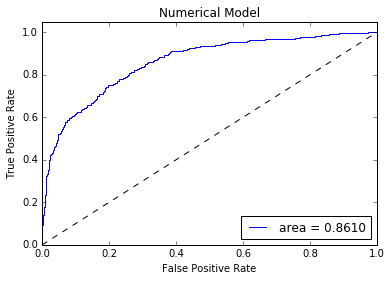

In [24]:
# to make these coefficients meaningful, scale with mean and variance
# scikit-learn for scaling, usually helps the convergence and accuracy
# for LR, SMV, Neural Networks, K-NN, always scale (decision trees don't need to scale)

import datetime
from pytz import timezone
from dateutil import tz
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
np.random.seed(0)

#Setting up logic to identify timezone, weekend, and holidays
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/Chicago')
# assume weekend is Friday/Saturday
weekend = set([5, 6])
cal = calendar()
holidays = cal.holidays(start='2011-04-07', end='2013-10-11')

#Created new df for training data(numeric only)
train_data_numeric = np.zeros((len(train_data), 16))
dev_data_numeric =  np.zeros((len(dev_data), 16))

find_image = re.compile(r'(imgur\.com|\.jpg)')  #compile this to combine with other function

#####Process train data set###########################################################
ut = train_data['unix_timestamp_of_request_utc']
temp =  ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =   temp.apply(lambda x: x.replace(tzinfo=from_zone))

#For UTC and local time conversion
temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])
    
train_data_numeric[:,0] = train_data['request_title'].apply(lambda x: len(x.split(' ')))  #Title length
train_data_numeric[:,1] = train_data['request_text'].apply(lambda x: len(x.split(' ')))   #Text length
train_data_numeric[:,2] = temp['T'].dt.month      #Month in integer
train_data_numeric[:,3] = temp['T'].dt.day > 15   #2nd 1/2 month
train_data_numeric[:,4] = temp['T'].dt.hour > 12  #Passed noon
train_data_numeric[:,5] = train_data['requester_upvotes_minus_downvotes_at_retrieval']
train_data_numeric[:,6] = train_data['requester_account_age_in_days_at_retrieval']
#Request during weekend
train_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend)
#Has Image: experiment with request_text over request_text_edit_aware, and use post_was_edited below it
train_data_numeric[:,8] = train_data['request_text'].apply(lambda x: 1 if find_image.findall(x) else 0 )
#Requested date a holiday
train_data_numeric[:,9] = (train_data['unix_timestamp_of_request_utc']
                           .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                           .apply(lambda x: 1 if x in holidays else 0))
#Post was edited
train_data_numeric[:,10] = train_data['post_was_edited']==1
train_data_numeric[:,11] = train_data['request_number_of_comments_at_retrieval']>1
train_data_numeric[:,12] = train_data['requester_number_of_posts_on_raop_at_retrieval']>1
# dont split on ; or ?, as it lowers the result
train_data_numeric[:,13] = train_data['request_text'].apply(lambda x: len(re.split(r'[.]',x)))>3 #proxy num sentences
train_data_numeric[:,14] = train_data['request_text'].apply(lambda x: avgNumWords(x))>15 #proxy avg num words per sentence
train_data_numeric[:,15] = monthsFrom2010(train_data['unix_timestamp_of_request_utc']) #months from raop creation in 12/2010

######################Omitted Variables due to less significance####################
#Is the text edited and included image: train_data['request_text_edit_aware'].apply(lambda x: 1 if find_image.findall(x) else 0 )
#Number of comments at time of retrieval: train_data['requester_number_of_comments_in_raop_at_retrieval']>1
#Number of posts at time of retrieval: train_data['requester_number_of_posts_at_retrieval']>1
#Create a table to show cofficients of the key numerical features
num_features = pd.DataFrame(index=['# words in posted title', 
                                   '# words in posted text', 
                                   'Month number of post (1-12)', 
                                   'Posted 2nd half of month?', 
                                   'Posted past noon CST?', 
                                   'Upvotes minus Downvotes', 
                                   'Requester account age', 
                                   'Posted on weekend?', 
                                   'Requester included image?', 
                                   'Posted on holiday?',
                                   'Post edited by Reddit?', 
                                   '# comments on Reddit at retrieval > 1', 
                                   '# posts on RAOP at retrieval > 1',
                                   'Number of sentences > 3', 
                                   'Average words in sentence > 15', 
                                   '# Months since RAOP creation 12/2010'])

#######Process dev dataset, setting up the same features for dev##############################################
ut = dev_data['unix_timestamp_of_request_utc']
temp = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp = temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =  temp.apply(lambda x: x.replace(tzinfo=from_zone))

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])

dev_data_numeric[:,0] = dev_data['request_title'].apply(lambda x: len(x.split(' '))) 
dev_data_numeric[:,1] = dev_data['request_text'].apply(lambda x: len(x.split(' ')))
dev_data_numeric[:,2] = temp['T'].dt.month
dev_data_numeric[:,3] = temp['T'].dt.day > 15
dev_data_numeric[:,4] = temp['T'].dt.hour > 12 
dev_data_numeric[:,5] = dev_data['requester_upvotes_minus_downvotes_at_retrieval']
dev_data_numeric[:,6] = dev_data['requester_account_age_in_days_at_retrieval']>1
dev_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend) # Request during weekend
dev_data_numeric[:,8] =  dev_data['request_text'].apply(lambda x: 1 if find_image.findall(x) else 0 )
dev_data_numeric[:,9] = (dev_data['unix_timestamp_of_request_utc']
                         .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                         .apply(lambda x: 1 if x in holidays else 0))
dev_data_numeric[:,10] = dev_data['post_was_edited']==1
dev_data_numeric[:,11] = dev_data['request_number_of_comments_at_retrieval']>1
dev_data_numeric[:,12] = dev_data['requester_number_of_posts_on_raop_at_retrieval']>1
dev_data_numeric[:,13] = dev_data['request_text'].apply(lambda x: len(re.split(r'[.]',x)))>3  #proxy num sentences
dev_data_numeric[:,14] = dev_data['request_text'].apply(lambda x: avgNumWords(x))>15  #proxy avg num words per sentence
dev_data_numeric[:,15] = monthsFrom2010(dev_data['unix_timestamp_of_request_utc'])  #months from raop creation in 12/2010
      
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# pipeline is like a dict of models you have

#------------------------------------------
###Start Logistic Regresson on numeric data
sc = StandardScaler()

# weights = {0: 0.5, 1: 100}
# invoke StandardScaler, sc, and use balanced weight

# positive classes will be around 25%
# if send unbalanced dataset to model, it will learn it, LR is trying to learn the true probability of getting a pizza
# naive prediction is 25%
# but with roc, don't care about probability, only ranking, 
# analyze more errors for class with less examples
# every time it sees an error for positive, it will penalize 4 times the error (if it wasn't balanced), so it sees negative 
# and postives as the same weight (penalized x 1 vs. x 4)

logit = make_pipeline(sc, LogisticRegression(C= 0.1, penalty = 'l2', class_weight='balanced'))
result = logit.fit(train_data_numeric, train_labels)

preds = logit.predict(dev_data_numeric)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = logit.predict_proba(dev_data_numeric)

#anova_svm.named_steps['anova'].get_support()
#Table show which numerical coefficients got higher weights
num_features["Coefficients"] = pd.Series(logit.named_steps['logisticregression'].coef_[0], index=num_features.index)
print (num_features)
print

table_of_thresholds = model_output(pred_probas, F_Score, preds, "Numerical Model")

15 numeric features yield a surprisingly high area under the ROC curvey = 0.8610, with a relatively close balance between precision and accuracy and thus a harmonic mean F-Score that is similar. 

- The numeric feature -- number of posts on the Subreddit (Random Acts of Pizza) at retrieval > 1 -- accounts for the highest absolute value coefficient at 1.10.
- The numeric feature -- number of comments on Reddit overall at retrieval > 1 -- reveals the second highest at 0.940215.
- In practice, the Kaggle test dataset should involve people who posted requests after 2013. But, in this case, their test dataset is restricted to 2010-2013, and thus we can leverage custom numeric features such as requester's Reddit account age, and the number of months between the date of their pizza post and the 12/2010 Subreddit creation.



# 5. Text Feature Engineering

# 5.a. First explore preliminary models and uni-grams / bi-grams on text

In [25]:
import operator

def explore_models():
    
    # create empty vector
    accuracies = []
    
    vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
    train_vectors = vectorizer.fit_transform(train_text)
    print ("train_vectors.shape:", train_vectors.shape)
    
    dev_vectors = vectorizer.transform(dev_text)
    print ("dev_vectors.shape:", dev_vectors.shape), '\n'
    
    #------------------------
    # K Nearest Neighbors
    #------------------------
    
    print ("------------------------------")
    print ("K Nearest Neighbors (K-NN)")
    print ("------------------------------")
    
    ks = [1, 5, 15, 16, 17, 18, 19, 20, 28, 29, 30, 31, 32, 150, 300]
    f1_scores = []
    
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        knn.fit(train_vectors, train_labels)
        pred_1 = knn.predict(dev_vectors)
            
        print ("K-NN: f1_score = %s, k = %s" %(round(metrics.f1_score(dev_labels, pred_1, average='binary'),4), k))

        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_1))
    
    print
    
    # map two vectors into a dictionary
    results_knn = dict(zip(ks, f1_scores))
    #print (results_knn)
    
    # print (the key with the max fl_score
    print ("K-NN: optimal k =", max(results_knn.items(), key=operator.itemgetter(1))[0]), '\n'

    
    #------------------------
    # Bernoulli Naive Bayes
    #------------------------
    
    print ("-----------------------------")
    print ("Bernoulli Naive Bayes (BNB)")
    print ("-----------------------------")
    
    # create two vectors
    
    alphas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.094, 0.095, 0.096, 0.1, 0.105, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 10.0]
    f1_scores = []
    
    for a in alphas:
        bnb = BernoulliNB(alpha=a,binarize=0.5)
        bnb.fit(train_vectors, train_labels)
        pred_2 = bnb.predict(dev_vectors)
        print ("BNB: f1_score = %s, alpha = %s" % (round(metrics.f1_score(dev_labels, pred_2, average='binary'), 4), a))
        
        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_2))
        
    print
    
    # map two vectors into a dictionary
    results_bnb = dict(zip(alphas, f1_scores))
    #print (results_mnb)
    
    # print (the key wit)h the max fl_score
    print ("Bernoulli Naive Bayes: optimal alpha =", max(results_bnb.items(), key=operator.itemgetter(1))[0]), '\n'
    
    #------------------------
    # Logistic Regression
    #------------------------
    
    print ("------------------------")
    print ("Logistic Regression (LR)")
    print ("------------------------"), '\n'

    
    # create two vectors
    # cs refers to the vector of C (inverse of regularization strength) values
    
    cs = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, \
          10, 12, 20, 30, 40, 50, 100, 1000]
    f1_scores = []
    
    for c in cs:
        
        # use l2 regularization, per instructions
        lr = LogisticRegression(penalty='l2',C=c)
        lr.fit(train_vectors, train_labels)
        pred_3 = lr.predict(dev_vectors)
        
        print ("-------------------------------")
        print ("LR: f1_score = %s, C = %s" % (round(metrics.f1_score(dev_labels, pred_3, average='binary'),4), c))
        print ("-------------------------------")
        
        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_3, average='binary'))
        
        accuracies.append((lr.score(dev_vectors, dev_labels))*100) 

        #print (lr.coef_.shape)
        
        # first define function that squares a given value, for later use in the 'for loop' below
        fun_sq_wts = lambda x: x**2
        
        # use map function, likely faster (because written in C) than list comprehension.
        # map function itself applies a function, specifically the first argument on the second argument.
        # from coef_, take raw weights (coefficient of the features in the decision function), 
        # and sum the squares of these weights.

        # note: averege=weight vs. average=default should be about same score if similar number of examples across classes
        sq_wts = map(fun_sq_wts, lr.coef_[0])
        sum_sq_wts =  sum(sq_wts)
        print ("Label = 1, sum of squared weights = %s" % (sum_sq_wts)), '\n'
        
    # map two vectors into a dictionary
    results_lr = dict(zip(cs, f1_scores))
    #print (results_lr)
    
    # print (the key with the max fl_score
    print ("Logistic Regression: optimal C = %s" % (max(results_lr.items(), key=operator.itemgetter(1))[0]))
    print ("max accuracy = %s" % (max(accuracies)))

explore_models()

('train_vectors.shape:', (3975, 12313))
('dev_vectors.shape:', (1696, 12313)) 

------------------------------
K Nearest Neighbors (K-NN)
------------------------------
K-NN: f1_score = 0.4133, k = 1
K-NN: f1_score = 0.0259, k = 5
K-NN: f1_score = 0.0, k = 15
K-NN: f1_score = 0.0, k = 16
K-NN: f1_score = 0.0, k = 17
K-NN: f1_score = 0.0, k = 18
K-NN: f1_score = 0.0, k = 19
K-NN: f1_score = 0.0, k = 20
K-NN: f1_score = 0.0, k = 28
K-NN: f1_score = 0.0, k = 29
K-NN: f1_score = 0.0, k = 30
K-NN: f1_score = 0.0, k = 31
K-NN: f1_score = 0.0, k = 32
K-NN: f1_score = 0.0, k = 150
K-NN: f1_score = 0.0, k = 300

('K-NN: optimal k =', 1) 

-----------------------------
Bernoulli Naive Bayes (BNB)
-----------------------------
BNB: f1_score = 0.0, alpha = 0.0
BNB: f1_score = 0.0844, alpha = 1e-05
BNB: f1_score = 0.0844, alpha = 0.0001
BNB: f1_score = 0.0844, alpha = 0.001
BNB: f1_score = 0.0125, alpha = 0.01
BNB: f1_score = 0.0126, alpha = 0.094
BNB: f1_score = 0.0126, alpha = 0.095
BNB: f1_score

/Users/Maximus/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1075: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
from sklearn.feature_selection import *

def top20(type):
    if type == "unigram":
        
        # use stop_words='english' to remove less meaningful words. 
        # only applies if default analyzer='word'.
        vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
        #vectorizer = CountVectorizer(min_df=1, stop_words='english')
        train_vectors = vectorizer.fit_transform(train_text)
        print
        print ("----------")
        print ("unigram")
        print ("----------")
        print
        print ("train_vectors.shape:", train_vectors.shape)
        print
        
    elif type == "bigram":
        
        # use stop_words='english' to remove less meaningful words from the resulting tokens. 
        # only applies if default analyzer='word'.
        # set bigrams to be 2 words only
        vectorizer = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2))
        #vectorizer = CountVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2))
        train_vectors = vectorizer.fit_transform(train_text)
        print
        print ("----------")
        print ("bigram")
        print ("----------")
        print
        print ("train_vectors.shape:", train_vectors.shape)
        print
      
    # use C=12
    for c in [12]:
        
        # in the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the default ‘multi_class’ option is set to ‘ovr’ 
        lr = LogisticRegression(penalty='l2',C=c)
        #print (lr)
        
        # fit the model and generate coef_
        lr.fit(train_vectors, train_labels)
         
        # interested in magnitude of the weights (coefficients), so take absolute value.
        # sort absolute values in descending order.
        # important to know if negative or positive weight, so still output the positive/negative sign.
        # after fitting logistic regression for class vs. all other classes, negative weight of a token 
        # indicates a class other than class of interest.
        # (visual example of negative and positive on a sigmoid function helps) 
        
        print ("lr.coef_:")
        print (lr.coef_), "\n"
        
        # for each label, store the column indices of the top 5 weights 
        top20 = sorted(range(len(lr.coef_[0])), key=lambda i: abs(lr.coef_[0][i]), reverse=True)[:20]
       
        col_1 = []
        
        # for each label, access and store weights via column indices
        for index in (top20):
            col_1.append(lr.coef_[0][index])
        # store feature names, after converting to an array
        feature_names = np.asarray(vectorizer.get_feature_names())
       
        # create a Pandas dataframe with 20 rows and 4 columns, plus descriptive headers
        df = pd.DataFrame({'Feature': feature_names[top20], 'word': col_1})
        print (df)

#-----
top20("unigram")
top20("bigram")


----------
unigram
----------

('train_vectors.shape:', (3975, 12313))

lr.coef_:
[[-1.48092905 -0.39311615 -0.12825177 ...,  0.44453487  1.63180069
  -0.87946286]] 

       Feature      word
0         edit  4.824324
1       father  4.627494
2         mean  4.376547
3      pockets  4.057164
4          ass  3.995387
5    mentioned  3.977975
6          die  3.930683
7        basic  3.899384
8      married  3.850098
9     southern -3.846223
10       bloke  3.807984
11    surprise  3.805289
12   graveyard  3.749854
13   surprised  3.697465
14     sitting -3.697393
15       mommy  3.658543
16  especially  3.627059
17  constantly  3.593246
18      cheesy  3.548595
19     running  3.539010

----------
bigram
----------

('train_vectors.shape:', (3975, 90693))

lr.coef_:
[[-0.31775435  0.42001296 -0.29407174 ..., -0.26401881 -0.22234693
   0.57766744]] 

                Feature      word
0           edit thanks  3.882043
1             imgur com  3.879634
2            http imgur  3.547851
3   

# 5.b. Dive into text feature engineering

In [27]:
# 0a.Extract text and tile for train and dev

train_text=train_data['request_text'].as_matrix()
train_title=train_data['request_title'].as_matrix()
train_all = train_text+train_title

dev_text=dev_data['request_text'].as_matrix()
dev_title=dev_data['request_title'].as_matrix()
dev_all = dev_text + dev_title
# create tf-idf for the text, then the title, or label each

In [28]:
# 0b.Helper Method

def train_log(train,dev):
    
    model_LG_func = LogisticRegression(penalty ='l2',C=13)
    model_LG_func.fit(train, np.ravel(train_labels))
    
    preds_train = model_LG_func.predict(train)
    F_Score_train = metrics.f1_score(train_labels, preds_train, average='binary')
    pred_probas_train = model_LG_func.predict_proba(train)

    preds = model_LG_func.predict(dev)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG_func.predict_proba(dev)

    #Call to display outputs
    model_output(pred_probas, F_Score, preds)
    fpr,tpr,thresholds = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc_dev = metrics.auc(fpr,tpr)
    fpr,tpr,_ = roc_curve(train_labels, pred_probas_train[:,1])
    roc_auc_train = metrics.auc(fpr,tpr)
    
    print

Preprocessor

In [29]:
from scipy import sparse
from scipy.sparse import csr_matrix 
from scipy.sparse import coo_matrix, hstack
from bs4 import BeautifulSoup

def empty_preprocessor(s):
    return s

# one good practice is to preceed with r string, than with just the string
# r"string" (sometimes regex doesn't work without that)
def first_preprocessor(s):
    #convert to lowercase
    s=s.lower()
    s=re.sub("[,.!?:;/~*]"," ",s)
    #remove duplicated 0s and 1s
    s=re.sub("[0-9]*","",s)
    #remove number longer than 5 digit
    s=re.sub("[0-9]{5,}","",s)
    #remove stem end with 'ly'
    s=re.sub("ly\s"," ",s)
    #remove plural form
    s=re.sub("s\s"," ",s)
    s=re.sub("s\Z"," ",s)
    #remove _ as the end of word
    s=re.sub("[_]+"," ",s)
    #remove _ as start of the word
    s=re.sub("\s[_]+"," ",s)
    #remove stem end with 'ness'
    s=re.sub("ness\s"," ",s)
    s=re.sub("ing\s"," ",s)
    #remove words that are too short
    s=re.sub("\s[0-9a-z]{1,2}\s"," ",s)
    s=re.sub("\s[0-9a-z]{1,2}\Z"," ",s)
    s = BeautifulSoup(s).get_text()
    return s

def second_preprocessor(s):
    
    # make all text lowercase
    s = s.lower()
    
    # replace digit(s) with an uncommon string,'zz'
    s = re.sub("\d+", "zz", s)
    
    # stem words with specific endings
    s=re.sub("ness\s"," ",s)
    s=re.sub("ing\s"," ",s)

    #remove _ as the end of word
    s=re.sub("[_]+"," ",s)
    #remove _ as start of the word
    s=re.sub("\s[_]+"," ",s)
    
    #-----
    # write variation of code, but remove ending s (make plural words singular)
    # http://stackoverflow.com/questions/3675318/how-to-replace-the-some-characters-from-the-end-of-a-string
    def replace_ending_s(orig_string):
        head, sep, tail = orig_string.rpartition("s")
        if orig_string[len(orig_string)-1] in ("s"):
            return head
        else:
            return orig_string
    
    if len(s) >= 3:
        s = replace_ending_s(s)
    #----- 
    
    # replace 2-3 blank spaces with 1 blank space
    s = re.sub("   ", " ", s)
    s = re.sub("  ", " ", s)
    
    # return preprocessed string
    return s

Preprocessor testing and vectorizer comparision

In this session, we compare different ways to turn text into feature matrix.  The results show our preprocessing effors were not very successful and the best results come from TF-IDF vectorizer with ngram_range from 1 to 8. 

Number of positive prediction: 69
Model F-Score = 0.0984 
Accuracy = 0.7300
precision_score: 0.362319
recall_score: 0.0569
roc_auc_score: 0.5820

Number of positive prediction: 36
Model F-Score = 0.0463 
Accuracy = 0.7329
precision_score: 0.305556
recall_score: 0.0251
roc_auc_score: 0.5888

Number of positive prediction: 48
Model F-Score = 0.0616 
Accuracy = 0.7305
precision_score: 0.312500
recall_score: 0.0342
roc_auc_score: 0.6030

Number of positive prediction: 179
Model F-Score = 0.2492 
Accuracy = 0.7264
precision_score: 0.430168
recall_score: 0.1754
roc_auc_score: 0.6335

Number of positive prediction: 186
Model F-Score = 0.2592 
Accuracy = 0.7270
precision_score: 0.435484
recall_score: 0.1845
roc_auc_score: 0.6311

Number of positive prediction: 187
Model F-Score = 0.2492 
Accuracy = 0.7229
precision_score: 0.417112
recall_score: 0.1777
roc_auc_score: 0.6329



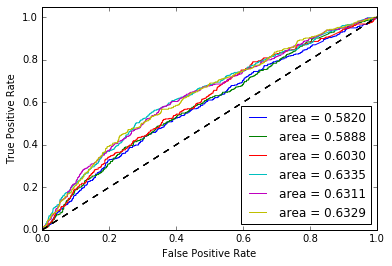

In [30]:
# compare 6 alternatives of text feature enginerin

# consider and try keeping the stop words, might help the classification

vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='char',stop_words='english')
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

vectorizer_process = CountVectorizer(preprocessor =first_preprocessor,analyzer='char',stop_words='english')
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

vectorizer_process = CountVectorizer(preprocessor =second_preprocessor,analyzer='char',stop_words='english')
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

# 1.Convert Text to word features based on TF-IDF
# gives sparse matrix

vectorizer_process = TfidfVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8))
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

vectorizer_process = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8))
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

vectorizer_process = TfidfVectorizer(preprocessor =second_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8))
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

# sometimes how people word things has some predictive value
# for search, stemming is ok, but how people write makes a difference for classification

Adding Narratives as features

In [31]:
#Text Feature Engineering: Add Narratives

desire = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving|gf)', re.IGNORECASE)
family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter|firstborn|pregnancy )', re.IGNORECASE)
job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work)', re.IGNORECASE)
money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|\
credit|budget|day|now|time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
mood = re.compile(r'(thank|thanks|thankful|appreciate|grateful|gratitude|advance)', re.IGNORECASE) 
holiday = re.compile(r'(anniversary|chirstmas)', re.IGNORECASE)   

def myfunc(a,b):
    if len(a)==0:
        return 0 
    else:
        return len(b.findall(a))/float(len(a))

In [32]:
narrative_all=np.zeros(shape=(len(train_text),6),dtype=int)
narrative_all_dev=np.zeros(shape=(len(dev_text),6),dtype=int)

for index,i in enumerate([family,desire,holiday,mood,job,money]):
    
    # in theory based on research,
    # count can capture more variation and perhaps more predictive power than binary linear relation
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_title+train_text,i)
    med=np.median(narrative)
    narrative_all[:,index]=narrative

    narrative_dev=vfunc(dev_title+dev_text,i)
    med=np.median(narrative_dev)
    narrative_all_dev[:,index]=narrative_dev


(3975, 809631)
(1696, 809631)
Number of positive prediction: 411
Model F-Score = 0.3976 
Accuracy = 0.6981
precision_score: 0.411192
recall_score: 0.3850
roc_auc_score: 0.6406


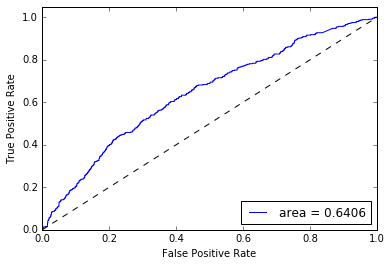

In [34]:
# for two arrays, concatenate tries to fill the sparse matrix
# hstack will put a matrix next to each other, without storing the 0s in memory

# train_narrative=np.concatenate((cv_features.toarray(), narrative_all), axis=1)
# dev_narrative=np.concatenate((cv_features_dev.toarray(), narrative_all_dev), axis=1)

from scipy.sparse import hstack, vstack

train_narrative = hstack((train_matrix_process_text, narrative_all))
dev_narrative = hstack((dev_matrix_process_text, narrative_all_dev))

print(train_narrative.shape)
print(dev_narrative.shape)

logistic = LogisticRegression(penalty ='l2',C=1)#C from the above test
logistic.fit(train_narrative, train_labels)

#preds = logistic.predict(dev_narrative)
pred_probas = logistic.predict_proba(dev_narrative)
preds = pred_probas[:,1] > 0.3 # the point we cut off our predictions for positive or negative, can affect f-score
F_Score = metrics.f1_score(dev_labels, preds, average='binary')

# Call to display outputs
model_output(pred_probas, F_Score, preds)

# f-score uses the threshold, class_weight seems to help, f-score is harmonic avg between precision and recall, 
# true positive rate is recall
# but precision is close but not the same as the false positive rate (likely just a coincidence)

Adding Capitalized word and Title as text features

(3975, 809632)
Number of positive prediction: 411
Model F-Score = 0.3976 
Accuracy = 0.6981
precision_score: 0.411192
recall_score: 0.3850
roc_auc_score: 0.6229


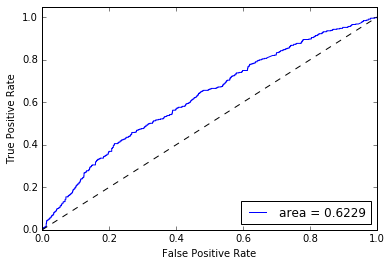

In [35]:
# Text Feature Engineering: Add capitalized word on Title

train_caps = train_data['request_title'].apply(lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 5) > 0, 1,0)).as_matrix()
dev_caps = dev_data['request_title'].apply(lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 5) > 0, 1,0)).as_matrix()
train_caps=train_caps.reshape(len(train_caps),1) 
dev_caps=dev_caps.reshape(len(dev_caps),1) 

train_narrative_excl_cap=hstack((train_narrative, train_caps))
dev_narrative_excl_cap=hstack((dev_narrative, dev_caps))
print(train_narrative_excl_cap.shape)

# use l1 feature selection, and then pass into l2, usually it doesn't work
# if l1 isn't good by itself, then it won't help l2
# l1 does the selection, so no need to pass to l2
# sometimes, l2 is better because it doesn't put a zero to a feature and consider it, when l1 will put to 0

#logistic = LogisticRegression(penalty ='l2',C=1,class_weight='balanced')
# usually try both, if more skewed (e.g., 5%) class_weight=balanced works better
# use two for loops (one for penalty, one for C), randomSearch can work faster than gridSearch
logistic = LogisticRegression(penalty ='l2',C= 0.1)#C from tuning experiments
logistic.fit(train_narrative_excl_cap, train_labels)

preds = logistic.predict(dev_narrative_excl_cap)
preds = pred_probas[:,1] > 0.3 # the point we cut off our predictions for positive or negative
pred_probas = logistic.predict_proba(dev_narrative_excl_cap)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')

# Call to display outputs
model_output(pred_probas, F_Score, preds)

We decided to use L1 regulation for our final text feature selection instead of Entropy method due to technicial issues.  We had tried feature seleciton methods such as GridSearch which can be found in the Appendix.  Works related to feature engineering using entropy method will likely to be discussed at presentation.

In [36]:
# L1 Regularization

for c in np.arange(0.5,18,0.5):
    
    Logistic_L1 = LogisticRegression(penalty ='l1',C=c)#C from the above test
    Logistic_L1.fit(train_narrative_excl_cap, np.ravel(train_labels))

    #Update the new index
    index=[]
    for i,z in enumerate(np.sum(np.abs(Logistic_L1.coef_),axis=0) ):
        if z!=0:
            index.append(i)

    train_features_final=train_narrative_excl_cap.tocsr()[:,index]
    dev_features_final=dev_narrative_excl_cap.tocsr()[:,index]

    Logistic_L2 = LogisticRegression(penalty ='l2',C= 0.1)#C from the above test
    Logistic_L2.fit(train_features_final, np.ravel(train_labels))

    preds = Logistic_L2.predict(dev_features_final)
    pred_probas = Logistic_L2.predict_proba(dev_features_final)
    F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')


    #Call to display outputs
#     model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    print ('With L1 hyper paramter C=%.2f, auc=%.5f, %i features selected. ' %(c,roc_auc,len(index)))

With L1 hyper paramter C=0.50, auc=0.49904, 1 features selected. 
With L1 hyper paramter C=1.00, auc=0.57290, 10 features selected. 
With L1 hyper paramter C=1.50, auc=0.58763, 25 features selected. 
With L1 hyper paramter C=2.00, auc=0.60123, 49 features selected. 
With L1 hyper paramter C=2.50, auc=0.63660, 77 features selected. 
With L1 hyper paramter C=3.00, auc=0.60748, 104 features selected. 
With L1 hyper paramter C=3.50, auc=0.61235, 145 features selected. 
With L1 hyper paramter C=4.00, auc=0.61455, 205 features selected. 
With L1 hyper paramter C=4.50, auc=0.60922, 260 features selected. 
With L1 hyper paramter C=5.00, auc=0.60894, 303 features selected. 
With L1 hyper paramter C=5.50, auc=0.60892, 351 features selected. 
With L1 hyper paramter C=6.00, auc=0.60804, 394 features selected. 
With L1 hyper paramter C=6.50, auc=0.60837, 444 features selected. 
With L1 hyper paramter C=7.00, auc=0.60875, 624 features selected. 
With L1 hyper paramter C=7.50, auc=0.60796, 712 featur

Test how the final text features' performance

Number of positive prediction: 4
Model F-Score = 0.0090 
Accuracy = 0.7412
precision_score: 0.500000
recall_score: 0.0046
roc_auc_score: 0.6367


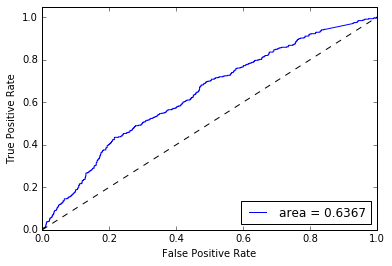

In [38]:
Logistic_L1 = LogisticRegression(penalty ='l1',C=2.5)#C from the above test
Logistic_L1.fit(train_narrative_excl_cap, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(Logistic_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

train_features_final=train_narrative_excl_cap.tocsr()[:,index]
dev_features_final=dev_narrative_excl_cap.tocsr()[:,index]

Logistic_L2 = LogisticRegression(penalty ='l2',C=1)#C from the above test
Logistic_L2.fit(train_features_final, np.ravel(train_labels))

preds = Logistic_L2.predict(dev_features_final)
pred_probas = Logistic_L2.predict_proba(dev_features_final)
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')


#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

# Model Optimization

Test the result with a basic logistic regression with previously determine hyperparameters c = 0.1 for both L1 and L2
The result yields a 0.8659, a pretty decent result

Number of positive prediction: 224
Model F-Score = 0.5792 
Accuracy = 0.8355
precision_score: 0.857143
recall_score: 0.4374
roc_auc_score: 0.8660


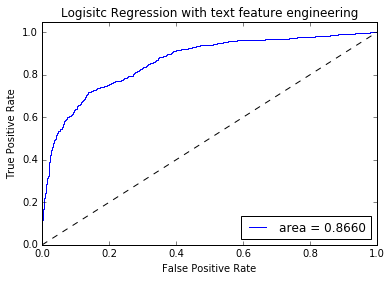

In [40]:
#Combine text features with numerical features; text features engineering from above
#train_features_final - training set text feature engineering
#dev_features_final -  dev set of text feature engineering
#train_data_numeric - training set of numerical features
#dev_data_numeric - dev set of numerical features
np.random.seed(0)

all_data_train = np.append(train_features_final.toarray(), train_data_numeric, 1)
model_LG = LogisticRegression(penalty ='l2', C = 0.1)#C from the above test
model_LG.fit(all_data_train, train_labels)


all_data_dev = np.append(dev_features_final.toarray(), dev_data_numeric, 1)

preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG.predict_proba(all_data_dev)

model_output(pred_probas, F_Score, preds, 'Logisitc Regression with text feature engineering')

Due to the restrictions of linearity of logistic regression; we tried using RandomForest to see if it yield beeter result.  With trail and error, we tuned the model at around 300 trees is sufficient for the random forest method to yield good result.  Interestingly, the best feature engineering we came up didn't seem to yield a better model than logistic regression.


Number of trees in forest: 10
Number of positive prediction: 279
Model F-Score = 0.4345 
Accuracy = 0.7606
precision_score: 0.559140
recall_score: 0.3554
roc_auc_score: 0.7369

Number of trees in forest: 300
Number of positive prediction: 318
Model F-Score = 0.6209 
Accuracy = 0.8308
precision_score: 0.738994
recall_score: 0.5353
roc_auc_score: 0.8511

Number of trees in forest: 500
Number of positive prediction: 295
Model F-Score = 0.6049 
Accuracy = 0.8290
precision_score: 0.752542
recall_score: 0.5057
roc_auc_score: 0.8420

Number of trees in forest: 1000
Number of positive prediction: 323
Model F-Score = 0.6299 
Accuracy = 0.8337
precision_score: 0.743034
recall_score: 0.5467
roc_auc_score: 0.8469

Number of trees in forest: 7000
Number of positive prediction: 313
Model F-Score = 0.6090 
Accuracy = 0.8267
precision_score: 0.731629
recall_score: 0.5216
roc_auc_score: 0.8486

Number of trees in forest: 1000
Number of positive prediction: 310
Model F-Score = 0.6061 
Accuracy = 0.8261

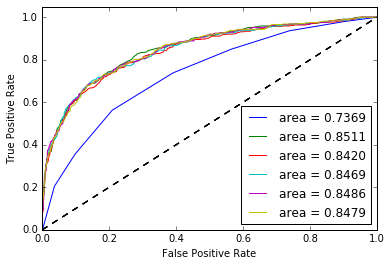

In [41]:
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 
#Best non-ensemble method so far
np.random.seed(0)

for i in [10, 300, 500, 1000, 7000, 1000]:

    # Create the random forest object which will include all the parameters
    forest = RandomForestClassifier(n_estimators = i)

    # Fit RandomForest
    # don't use transform method (at least not yet) -- which would reduce to best features -- 
    # as we want to keep and try these
    forest = forest.fit(all_data_train, train_labels)

    # Take the same decision trees and run it on the test data
    preds = forest.predict(all_data_dev)

    #preds = model_LG.predict(all_data_dev)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = forest.predict_proba(all_data_dev)

    print "\n", "Number of trees in forest: %s" % (i)
    #Call to display outputs
    model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

Below is best model we had at time of submission.
RandomForecast with at least 300 trees, using a standard CountVectorizer is better than TfidfVectorizer.
The model also worked best at with ngram_range between 1 and 8.  We found 1 to 8 grams worked better than bigram and unigram.  1 to 8 ngrams worked better because a particular type of phrase might be common in the text for a small percent of samples, and a model such as RF can pick up on that.  

Additionally, the result was optimal when applying "first_preprocessor", a version of preprocessor we built during text engineering phase that remove some things like "ly" or "plural forms"


Number of trees in forest: 300
Number of positive prediction: 215
Model F-Score = 0.5688 
Accuracy = 0.8337
precision_score: 0.865116
recall_score: 0.4237
roc_auc_score: 0.8692


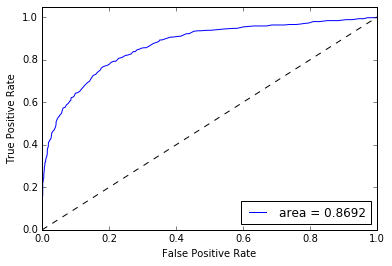

In [42]:
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 

#Best non-ensemble method so far
np.random.seed(0)

vectorizer_process = CountVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8))
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

#A GridSearch was performed and discover 0.1 works best for L1
index = L1_regulation(0.1, word_matrix_process, train_labels)

# Append along columns with axis=1. that is, append along x axis
# Combine numerical features with text features
all_data_train = 0
all_data_dev = 0
all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)
all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

for i in [300]:

    # Create the random forest object which will include all the parameters
    forest = RandomForestClassifier(n_estimators = i)

    # Fit RandomForest
    # don't use transform method (at least not yet) -- which would reduce to best features -- 
    # as we want to keep and try these
    forest = forest.fit(all_data_train, train_labels)


    # Take the same decision trees and run it on the test data
    preds = forest.predict(all_data_dev)

    #preds = model_LG.predict(all_data_dev)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = forest.predict_proba(all_data_dev)

    print "\n", "Number of trees in forest: %s" % (i)
    #Call to display outputs
    model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

# 6. Ensemble Method and Final Prediction

We wanted to see if we can further improve the AUC by using an Ensemble Method and leveraged different models.  
The Ensemble approach created two new features: probability of positive label predictions from Naive Bayes model and 
Logisitc Regression model.  The new features then were used to make predictions with a RandomForest alogrithm.    
Because RandomForest in previous results tend to work better with a simple CountVectorizer with L1 regulation, we decided to use the CountVectorizer to create the text features instead from text feature engineering results.

Number of positive prediction: 286
Model F-Score = 0.6097 
Accuracy = 0.8331
precision_score: 0.772727
recall_score: 0.5034
roc_auc_score: 0.8639


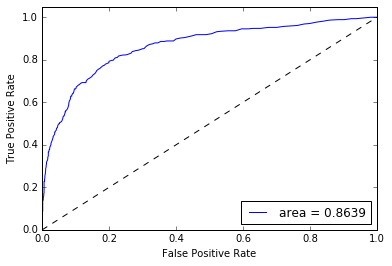

In [49]:
#Create inputs for Ensemble Method
#Ensemble Model = RF + NB + LG
vectorizer_process = CountVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8))
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

#Update the new index
index = L1_regulation(0.1, word_matrix_process, train_labels)

all_data_train = 0
all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)

all_data_dev = 0
all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

#Naive Bayes Predictor        
bnb = BernoulliNB(alpha=0.001, binarize=0.5)  #Hyper parameters approximations are from previous results
bnb.fit(all_data_train, train_labels)
NB_t = bnb.predict_proba(all_data_train)
NB_d = bnb.predict_proba(all_data_dev)

#Logistic Regression Predictor
model_LG = LogisticRegression(penalty ='l2', C=0.1)#C from the above test
model_LG.fit(all_data_train, train_labels)

LG_t = model_LG.predict_proba(all_data_train)
LG_d = model_LG.predict_proba(all_data_dev)

all_data_train = np.insert(all_data_train, all_data_train.shape[1], LG_t[:,1], axis=1)  #LG output
all_data_train = np.insert(all_data_train, all_data_train.shape[1], NB_t[:,1], axis=1)

all_data_dev = np.insert(all_data_dev, all_data_dev.shape[1], LG_d[:,1], axis=1)
all_data_dev = np.insert(all_data_dev, all_data_dev.shape[1], NB_d[:,1], axis=1)

for i in [300]:
# Create the random forest object which will include all the parameters
    forest = RandomForestClassifier(n_estimators = i)

# Fit the training data to the Survived labels and create the decision trees
    forest = forest.fit(all_data_train, train_labels)

# Take the same decision trees and run it on the test data
    preds = forest.predict(all_data_dev)

    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = forest.predict_proba(all_data_dev)
#Call to display outputs
    model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

# Final conclusion and model comparison
The results from Ensemble method is very close to a straight RandomForest approch if not slightly weaker.  This might 
be a result of overfitting.  Additionally, dding outputs from Naive Bayes as a feature actually hurts the AUC.  Perhaps the model is just not very good and using its results made things worst.  

Overall, simple logisitic regression seemed to work very well for this project.  This was initially a surprise until we learnt the predictive power mostly came from numerical features.  With RandomForest, we got additional gains in AUC
maybe becuase RF can utilize non-linear features better and yielded slightly better results.

# 7. Appendix

# Entropy Analysis not adapted

In [37]:
# GridSearch freezes window, comment out at least for now

# 2.Feature ranking with recursive feature elimination & cross-validated selection of the best number of features.
#import matplotlib.pyplot as plt
#from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold
#from sklearn.feature_selection import RFECV
#from sklearn.datasets import make_classification

# Build a LogisticRegression Classifier with L2 Regularization

#logistic  = LogisticRegression(penalty ='l2',C=1)

#rfecv = RFECV(estimator=logistic , step=0.1, cv=5,scoring='roc_auc')
#rfecv.fit(train_narrative_excl_cap, train_labels)

#print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
#plt.figure()
#plt.xlabel("Number of features selected")
#plt.ylabel("Cross validation score (roc_auc)")
#plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#plt.show()

#cv_features=train_narrative_excl_cap.tocsr()[:,rfecv.support_]
#cv_features_dev= dev_narrative_excl_cap.tocsr()[:,rfecv.support_]

#logistic = LogisticRegression(penalty ='l2',C=1)#C from the above test
#logistic.fit(cv_features, train_labels)


#preds = logistic.predict(cv_features_dev)
#pred_probas = logistic.predict_proba(cv_features_dev)
#F_Score = metrics.f1_score(dev_labels, preds, average='binary')


# Call to display outputs
#model_output(pred_probas, F_Score, preds)
#fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
#roc_auc = metrics.auc(fpr,tpr)
#print(roc_auc)


plot the words by its importance of ranking
#since we are reducing by 10% each time, you can see a lot of the words are in the same bucket and have the same ranking
#data=sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), vectorizer_process.get_feature_names()))[:100]
#df = pd.DataFrame(data)
#df.columns = ['Ranking', 'Words']
#df

# GridSearch freezes window, comment out at least for now

# 2.Feature ranking with recursive feature elimination & cross-validated selection of the best number of features.
# if it is run slow for you, change step from 1 to 0.1. should return instantly.
#import matplotlib.pyplot as plt
#from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold
#from sklearn.feature_selection import RFECV
#from sklearn.datasets import make_classification

# Build a LogisticRegression Classifier with L2 Regularization

#logistic  = LogisticRegression(penalty ='l2',C=1)

#rfe = RFE(estimator=logistic , n_features_to_select=500,step=0.1)
#rfe.fit(train_narrative_excl_cap, train_labels)

# Plot number of features VS. cross-validation scores
#plt.figure()
#plt.xlabel("Number of features selected")
#plt.ylabel("Cross validation score (roc_auc)")
#plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#plt.show()

#cv_features=train_narrative_excl_cap.tocsr()[:,rfe.support_]
#cv_features_dev= dev_narrative_excl_cap.tocsr()[:,rfe.support_]

#logistic = LogisticRegression(penalty ='l2',C=1)#C from the above test
#logistic.fit(cv_features, train_labels)


#preds = logistic.predict(cv_features_dev)
#pred_probas = logistic.predict_proba(cv_features_dev)
#F_Score = metrics.f1_score(dev_labels, preds, average='binary')


# Call to display outputs
#model_output(pred_probas, F_Score, preds)
#fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
#roc_auc = metrics.auc(fpr,tpr)
#print(roc_auc)

#plot the words by its importance of ranking
#data=sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), vectorizer_process.get_feature_names()))[:100]
#df = pd.DataFrame(data)
#df.columns = ['Ranking', 'Word']
#df

SyntaxError: invalid syntax (<ipython-input-37-5dd9586e5938>, line 45)

**Source**: Althoff, T., Danescu-Niculescu-Mizil, C., & Jurafsky, D. (2014). *How to Ask for a Favor: A Case Study on the Success of Altruistic Requests*. Association for the Advancement of Artificial
Intelligence (www.aaai.org).

- "The community only publishes which users have given or received pizzas but not which requests were successful. 
In the case of successful users posting multiple times it is unclear which of the requests was actually successful. 
Therefore, we restrict our analysis to users with a single request for which we can be certain whether or not 
it was successful, leaving us with 5728 pizza requests. We split this dataset into development (70%) and test set (30%) such that both sets mirror the average success rate in our dataset of 24.6%. All features are developed on the 
development test only while the test set is used only once to evaluate the prediction accuracy of our proposed model on held-out data. For a small number of requests (379) we further observe the identity of the benefactor through a 
'thank you' post by the beneficiary after the successful request. This enables us to reason about the impact of 
user similarity on giving."


- "It is extremely difficult to disentangle the effects of all these factors in determining what makes people satisfy requests, and what makes them select some requests over others. . . In this paper, we develop a framework for controlling for each of these potential confounds while studying the role of two aspects that characterize compelling requests: **social factors** (who is asking and how the recipient is related to the donor and community) and **linguistic factors** (how they are asking and what linguistic devices accompany successful requests). With the notable exception of Mitra and Gilbert (2014), the effect of language on the success of requests has largely been ignored thus far."


- "[Their] goal is to understand what motivates people to give when they do not receive anything tangible in return. That is, [they] focus on the important special case of altruistic requests in which the giver receives no rewards." **DSC**: But how do you know people don't want something in return, especially if they are more likely to help requesters who have high status or are more similar to them?

-----

Temporal Factors
- Specific months
- Weekdays
- **Days of the month (first half of the month)**
- Hour of the day
- **Community age of the request (earlier the better)**

Textual Factors
- Politeness (e.g., **gratitude**)
- **Evidentiality** (2nd largest parameter estimate)
- Reciprocity (respond to a positive action with another positive action, **pay it forward**)
- Sentiment (e.g., **urgency**)
- **Length**

Social Factors
- **Status**
    - karma points (up-votes minus down-votes) that Reddit counts on link submissions and comments,
    - user has posted on RAOP before and thus could be considered a member of the sub-community. 
    - **user account age based on the hypothesis that “younger” accounts might be less trusted**


- Similarity: intersection size between the set of the giver and receiver, and the Jaccard similarity (intersection
over union) of the two. NOT included in logistic regression model.

Narratives (identified through topic modeling)
- **Desire**
- **Family**
- **Job**
- **Money**
- Student

-----

Conclusion
- Drawing from social psychology literature [they] extract high-level social features from text that operationalize the relation between recipient and donor and demonstrate that these extracted relations are predictive of success. 
- [They] show that [they] can detect key narratives automatically that have significant impact on the success of the request. 
- [They] further demonstrate that linguistic indications of gratitude, evidentiality, and reciprocity, as well as the high status of the asker, all increase the likelihood of success, while neither politeness nor positive sentiment seem to be associated with success in [the] setting.

Limitations
- A shortcoming of any case study is that findings might be specific to the scenario at hand. While [they] have shown that particular linguistic and social factors differentiate between successful and unsuccessful requests [they] cannot claim a causal relationship between the proposed factors and success that would guarantee success. 
- Furthermore, the set of success factors studied in this work is likely to be incomplete as well and excludes,
for instance, group behavior dynamics. 
- Despite these limitations, [they] hope that this work and the data [they] make available will provide a basis for further research on success factors and helping behavior in other online communities.

-----